# Supervised graph classification with Deep Graph CNN

## StellarGraph 

### 1. 환경 요구사항
- Python 3.9 이하 버전 호환 (Colab은 Python 3.11 고정으로 실행 불가)

### 2. 데이터 제공 문제
- PROTEINS 데이터셋 제공 링크에서 404에러 발생
- 직접 다운로드 후 로드로 수정
- [PROTEINS.zip 다운로드](https://github.com/mjcho7/DeepLearning/raw/master/PROTEINS.zip)

### 3. 테스트 결과
-  학습 시 Loss 폭발 (Exploding Loss)
   - 모델 학습 중 Loss 값이 점점 커지는 현상 발생 → 이는 데이터의 분포나 입력 특성이 잘못되었음을 의미
   - Epoch가 진행될수록 loss 값이 증가하며 val_loss도 급증하는 패턴

### 4. 예상되는 주요 원인
- node_attributes 차원 문제 
   - node_attributes가 원래 4차원이어야 함 (StellarGraph 공식 설명 기준)
   - but 다운받은 PROTEINS node_attributes 자체가 단일 숫자 벡터로 제공됨 (1차원)
   - 변환 시도 : node_labels를 One-Hot Encoding 후 node_attributes와 병합 → 4차원 완성 ( 공식문서 참조하여 아이디어 얻음 )
   - 그러나 데이터의 분포가 이상할 가능성 존재:
      - node_attributes 자체가 1차원이어서 변환하는 과정에서 의미적인 문제가 있을 수 있음
      - 예측 : 단순한 병합이 아닌, 특정 scaling이나 변환이 필요할 수도 있음

### 5. 최종 결과 및 확인 사항
   1) PROTEINS 데이터 변환 과정의 불확실성 존재

      - StellarGraph 패키지에서 제공하던 PROTEINS.load() 함수가 더 이상 지원되지 않음에 땨라
      - 직접 데이터를 다운받아 StellarGraph 형식으로 변환하는 과정에서 공식 문서에 명확하지 않은 부분이 존재
      - 특히 노드 속성 변환 과정에서 데이터셋의 원래 구조와 차이가 발생했을 가능성
      - 즉, 학습이 제대로 이루어지지 않는 가장 큰 원인은 PROTEINS 데이터 변환 과정의 불확실성으로 추정

   2) StellarGraph 패키지의 공식 데이터셋 지원 중단에 대한 의문 제기

      - 해당 패키지의 지속 가능성에 대한 의문을 제기, 최신 버전에서의 유지보수 여부 확인 필요 
      - 대체 가능 모델 고려 필요

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook demonstrates how to train a graph classification model in a supervised setting using the Deep Graph Convolutional Neural Network (DGCNN) [1] algorithm.

In supervised graph classification, we are given a collection of graphs each with an attached categorical label. For example, the PROTEINS dataset we use for this demo is a collection of graphs each representing a chemical compound and labelled as either an enzyme or not. Our goal is to train a machine learning model that uses the graph structure of the data together with any information available for the graph's nodes, e.g., chemical properties for the compounds in PROTEINS, to predict the correct label for a previously unseen graph; a previously unseen graph is one that was not used for training and validating the model.

The DGCNN architecture was proposed in [1] (see Figure 5 in [1]) using the graph convolutional layers from [2] but with a modified propagation rule (see [1] for details). DGCNN introduces a new `SortPooling` layer to generate a representation (also know as embedding) for each given graph using as input the representations learned for each node via a stack of graph convolutional layers. The output of the `SortPooling` layer is then used as input to one-dimensional convolutional, max pooling, and dense layers that learn graph-level features suitable for predicting graph labels.

**References**

[1] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))


In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [4]:
# verify that we're using the correct version of StellarGraph for this notebook
import sys
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [12]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

## Import the data

In [1]:
import zipfile
import pandas as pd
import numpy as np
import os
from stellargraph import StellarGraph

# 압축 해제
with zipfile.ZipFile("PROTEINS.zip", "r") as zip_ref:
    zip_ref.extractall("PROTEINS")

# 데이터 경로 설정
path = "./PROTEINS/PROTEINS"

# 1. 데이터 불러오기
edges = pd.read_csv(os.path.join(path, 'PROTEINS_A.txt'), header=None, names=["source", "target"])
graph_labels = pd.read_csv(os.path.join(path, 'PROTEINS_graph_labels.txt'), header=None, names=["label"])
graph_indicator = pd.read_csv(os.path.join(path, 'PROTEINS_graph_indicator.txt'), header=None, names=["graph_id"])
node_labels = pd.read_csv(os.path.join(path, 'PROTEINS_node_labels.txt'), header=None, dtype="category")

# 2. 노드 속성 로드 (올바른 방식 적용)
node_attributes = pd.read_csv(
    os.path.join(path, "PROTEINS_node_attributes.txt"),
    header=None,
    dtype=np.float32  # 확실하게 float32로 설정
)

# 3. One-Hot Encoding 적용 (기존 node_labels 문제 해결)
node_labels_encoded = pd.get_dummies(node_labels)

# 4. 노드 속성과 병합하여 4차원 노드 속성 생성
node_features = pd.concat([node_labels_encoded, node_attributes], axis=1)

# 5. 그래프 ID 정리 (0부터 시작)
edges["source"] -= 1
edges["target"] -= 1
graph_indicator["graph_id"] -= 1

# 6. StellarGraph 형식으로 변환
graphs = []
unique_graphs = graph_indicator["graph_id"].unique()

for graph_id in unique_graphs:
    # 현재 그래프에 속하는 노드 및 엣지 필터링
    node_mask = graph_indicator["graph_id"] == graph_id
    edge_mask = edges["source"].isin(graph_indicator[node_mask].index) & edges["target"].isin(graph_indicator[node_mask].index)

    # 노드 데이터 추출
    nodes = node_features.loc[node_mask]

    # 엣지 데이터 추출
    graph_edges = edges.loc[edge_mask]

    # StellarGraph 생성
    G = StellarGraph(nodes=nodes, edges=graph_edges)
    graphs.append(G)

print(f"데이터 로드 완료! 총 {len(graphs)}개의 그래프가 생성됨.")


데이터 로드 완료! 총 1113개의 그래프가 생성됨.


In [131]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 42, Edges: 162

 Node types:
  default: [42]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [162]
        Weights: all 1 (default)
        Features: none


In [132]:
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 27, Edges: 92

 Node types:
  default: [27]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [92]
        Weights: all 1 (default)
        Features: none


Summary statistics of the sizes of the graphs:

In [133]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1113.0,1113.0
mean,39.1,145.6
std,45.8,169.3
min,4.0,10.0
25%,15.0,56.0
50%,26.0,98.0
75%,45.0,174.0
max,620.0,2098.0


The labels are `1` or `2`:

In [134]:
graph_labels.value_counts().to_frame()

,0
label,
1,663
2,450


In [135]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class.

In [136]:
generator = PaddedGraphGenerator(graphs=graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `DeepGraphCNN` class together with standard `tf.Keras` layers `Conv1D`, `MapPool1D`, `Dropout`, and `Dense`. 

The model's input is the graph represented by its adjacency and node features matrices. The first four layers are Graph Convolutional as in [2] but using the adjacency normalisation from [1], $D^{-1}A$ where $A$ is the adjacency matrix with self loops and $D$ is the corresponding degree matrix. The graph convolutional layers each have 32, 32, 32, 1 units and `tanh` activations. 

The next layer is a one dimensional convolutional layer, `Conv1D`, followed by a max pooling, `MaxPool1D`, layer. Next is a second `Conv1D` layer that is followed by two `Dense` layers the second used for binary classification. The convolutional and dense layers use `relu` activation except for the last dense layer that uses `sigmoid` for classification. As described in [1], we add a `Dropout` layer after the first `Dense` layer.

![](dgcnn_architecture.png)

First we create the base DGCNN model that includes the graph convolutional and `SortPooling` layers.

In [137]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Next, we add the convolutional, max pooling, and dense layers.

In [138]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

Finally, we create the `Keras` model and prepare it for training by specifying the loss and optimisation algorithm.

In [139]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

### Train the model

We can now train the model using the model's `fit` method.

But first we need to split our data to training and test sets. We are going to use 90% of the data for training and the remaining 10% for testing. This 90/10 split is the equivalent of a single fold in the 10-fold cross validation scheme used in [1].

In [140]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

Given the data split into train and test sets, we create a `StellarGraph.PaddedGenerator` generator object that prepares the data for training. We create data generators suitable for training at `tf.keras` model by calling the latter generator's `flow` method specifying the train and test data.

In [141]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

**Note**: We set the number of epochs to a large value so the call to `model.fit(...)` later might take a long time to complete. For faster performance set `epochs` to a smaller value; but if you do accuracy of the model found may be low.

In [142]:
epochs = 30

We can now train the model by calling it's `fit` method.

In [143]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/30
21/21 [==============================] - 4s 95ms/step - loss: -6.6420 - acc: 0.5634 - val_loss: -32.0535 - val_acc: 0.5982
Epoch 2/30
21/21 [==============================] - 2s 78ms/step - loss: -173.8140 - acc: 0.5954 - val_loss: -564.9880 - val_acc: 0.5982
Epoch 3/30
21/21 [==============================] - 2s 77ms/step - loss: -1548.2250 - acc: 0.5954 - val_loss: -3643.8762 - val_acc: 0.5982
Epoch 4/30
21/21 [==============================] - 2s 82ms/step - loss: -7033.9019 - acc: 0.5954 - val_loss: -14161.0967 - val_acc: 0.5982
Epoch 5/30
21/21 [==============================] - 2s 80ms/step - loss: -22709.9863 - acc: 0.5954 - val_loss: -41300.3945 - val_acc: 0.5982
Epoch 6/30
21/21 [==============================] - 2s 77ms/step - loss: -57567.8633 - acc: 0.5954 - val_loss: -99240.5000 - val_acc: 0.5982
Epoch 7/30
21/21 [==============================] - 2s 80ms/step - loss: -127773.2031 - acc: 0.5954 - val_loss: -207970.5781 - val_acc: 0.5982
Epoch 8/30
21/21 [=======

Let us plot the training history (losses and accuracies for the train and test data).

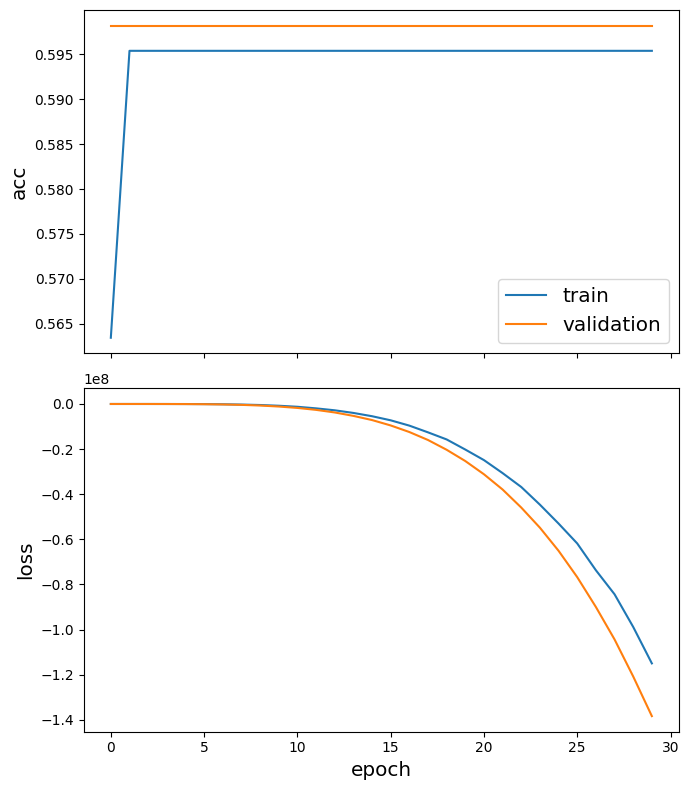

In [144]:
sg.utils.plot_history(history)

Finally, let us calculate the performance of the trained model on the test data.

In [145]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

112/112 [==============================] - 0s 2ms/step - loss: -138385136.0000 - acc: 0.5982

Test Set Metrics:
	loss: -138385136.0000
	acc: 0.5982


### Conclusion

We demonstrated the use of `StellarGraph`'s `DeepGraphCNN` implementation for supervised graph classification algorithm. More specifically we showed how to  predict whether a chemical compound represented as a graph is an enzyme or not.

Performance is similar to that reported in [1] but a small difference does exist. This difference can be attributed to a small number of factors listed below, 
- We use a different training scheme, that is a single 90/10 split of the data as opposed to the repeated 10-fold cross validation scheme used in [1]. We use a single fold for ease of exposition. 
- The experimental evaluation scheme in [1] does not specify some important details such as: the regularisation used for the neural network layers; if a bias term is included; the weight initialization method used; and the batch size.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>